<a href="https://colab.research.google.com/github/cszafariqbal/Deep_Learning_Projects/blob/main/flowers_Image_recognize_projects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Identitfy the flowers species using deep learning putorch
This project is the result of the knowledge acquired during the course Deep Learning with PyTorch.

For this project, was chosen the kaggle flowers image recognize Dataset which contains images of flowers species sperated in 5 categories. The main goal of the project is to define, train and test a neural network model for classifying images.

we are going to do it in the following step:

1. Pick a dataset
2. Download the dataset
3. Import the Dataset using pytorch
4. Explore the Dataset
5. Prepare the Dataset for Training
6. move the dataset to GPU
7. Define the neural network
8. Train th model
9. Make prediction on sample images itrate on it with diffrent network & hyperparametrs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Download the dataset
Using 'Opendatasets' and download the dataset from  https://www.kaggle.com/datasets/alxmamaev/flowers-recognition.

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od
import os
import torch
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import figure
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
download_url = 'https://www.kaggle.com/datasets/alxmamaev/flowers-recognition'

In [ ]:
od.download(download_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: zeeooma
Your Kaggle Key: ··········


100%|██████████| 225M/225M [00:03<00:00, 73.1MB/s]


In [ ]:
data_dir = './flowers-recognition/flowers'

In [ ]:
os.listdir(data_dir)

['sunflower', 'daisy', 'dandelion', 'rose', 'tulip']

In [ ]:
for cls in os.listdir(data_dir):
  print(cls, ':', len(os.listdir(data_dir + '/' + cls)))

sunflower : 733
daisy : 764
dandelion : 1052
rose : 784
tulip : 984


# Import the Dataset from pytorch
using the 'ImageFolder' from torchvision

In [ ]:

dataset = ImageFolder(data_dir, transform = tt.Compose([
    tt.Resize(64), tt.RandomCrop(64), tt.ToTensor()]))

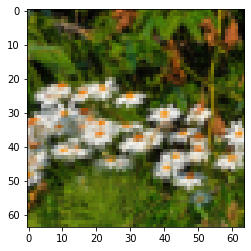

In [ ]:

image, label = dataset[112]
plt.imshow(image.permute(1,2,0))

In [ ]:
size_per = 0.1
valid_size = int(len(dataset) * size_per)
train_size = len(dataset) - valid_size

In [ ]:

train_ds, valid_ds = random_split(dataset, [train_size, valid_size])
len(train_ds), len(valid_ds)

(3886, 431)

In [ ]:

batch_size = 128
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, num_workers=4, pin_memory=True)


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Let's take a look at some sample images from the training dataloader.



In [ ]:
def show_batch(dl):
  for image, _ in dl:
    px, ax = plt.subplots(figsize=(16,12))
    ax.set_xticks([]), ax.set_yticks([])
    ax.imshow(make_grid(image, nrow=16).permute(1,2,0))
    break


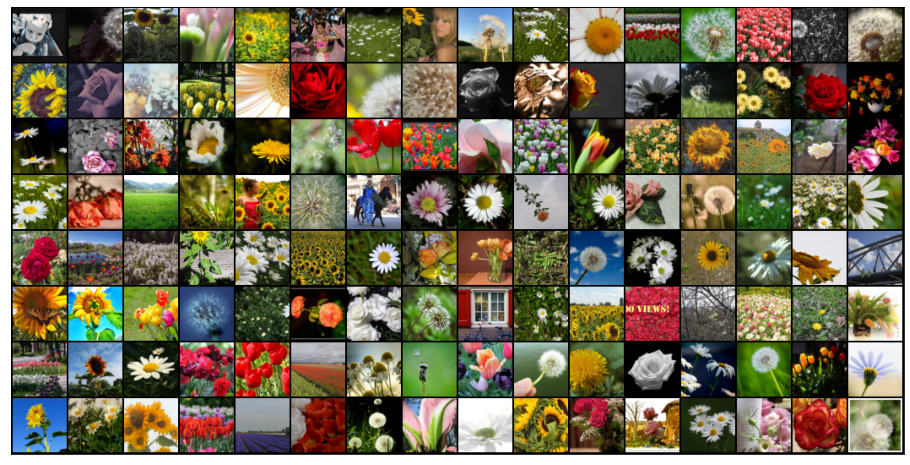

In [ ]:
show_batch(train_dl)



```
# This is formatted as code
```

## GPU Utility
We will use a couple of helper tools to use a GPU smoothly. Some helper functions and a helper class were defined to move our model and data to the GPU as needed.

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


*Based on where you're running this notebook, your default device could be a CPU (torch.device('cpu')) or a GPU (torch.device('cuda'))*




In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = get_default_device()
device

device(type='cuda')

We can now wrap our training and validation data loaders using DeviceDataLoader for automatically transferring batches of data to the GPU (if available).



In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Model Training & utility
We will define our models by extending an ImageClassificationBase class which contains helper methods for training & validation in future steps:



In [ ]:
class ImageClassificationBase(nn.Module):
    """ calculate the loss of batch of training dataloader"""
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    """calculate the loss and accuracy of batch of validation dataloader"""
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))



In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

@torch.no_grad()
def evaluate(model, val_loader):
    """ Define the model's performance on validation set..."""
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

## Model
Next, we will train our models using the following functions:

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

## Pass one batch of input tensor through model

In [ ]:
torch.cuda.empty_cache
for batch in train_dl:
  images, labels = batch
  print("images_shape:", images.shape)
  print("image_device:", images.device)
  pred = model(images)
  print('pred_shape:', pred.shape)
  break

images_shape: torch.Size([128, 3, 64, 64])
image_device: cuda:0
pred_shape: torch.Size([128, 5])


In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.6131294965744019, 'val_acc': 0.17004653811454773}]

In [ ]:
%%time
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 1.5039, val_loss: 1.2284, val_acc: 0.5057
Epoch [1], train_loss: 1.0209, val_loss: 0.8497, val_acc: 0.6727
Epoch [2], train_loss: 0.8744, val_loss: 0.8174, val_acc: 0.6805
Epoch [3], train_loss: 0.8225, val_loss: 0.9325, val_acc: 0.6747
Epoch [4], train_loss: 0.7363, val_loss: 0.8418, val_acc: 0.7311
CPU times: user 5.32 s, sys: 3.41 s, total: 8.72 s
Wall time: 57.6 s


In [ ]:
history += fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)


Epoch [0], train_loss: 0.6313, val_loss: 0.6252, val_acc: 0.7646
Epoch [1], train_loss: 0.5494, val_loss: 0.5901, val_acc: 0.7992
Epoch [2], train_loss: 0.5263, val_loss: 0.6148, val_acc: 0.7677
Epoch [3], train_loss: 0.4965, val_loss: 0.5957, val_acc: 0.7867
Epoch [4], train_loss: 0.4635, val_loss: 0.5758, val_acc: 0.7925


In [ ]:
history += fit(5, 0.00001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.4259, val_loss: 0.5500, val_acc: 0.7989
Epoch [1], train_loss: 0.4091, val_loss: 0.5513, val_acc: 0.8076
Epoch [2], train_loss: 0.4096, val_loss: 0.5423, val_acc: 0.8037
Epoch [3], train_loss: 0.3962, val_loss: 0.5453, val_acc: 0.8120
Epoch [4], train_loss: 0.3929, val_loss: 0.5645, val_acc: 0.8048


In [ ]:
history += fit(5, 0.00001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.3940, val_loss: 0.5372, val_acc: 0.8101
Epoch [1], train_loss: 0.3934, val_loss: 0.5494, val_acc: 0.8053
Epoch [2], train_loss: 0.3780, val_loss: 0.5486, val_acc: 0.8135
Epoch [3], train_loss: 0.3820, val_loss: 0.5343, val_acc: 0.8101
Epoch [4], train_loss: 0.3665, val_loss: 0.5544, val_acc: 0.7955


In [ ]:
history += fit(3, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [0], train_loss: 0.4235, val_loss: 0.5737, val_acc: 0.8129
Epoch [1], train_loss: 0.3894, val_loss: 0.5584, val_acc: 0.7970
Epoch [2], train_loss: 0.3617, val_loss: 0.5316, val_acc: 0.8126


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

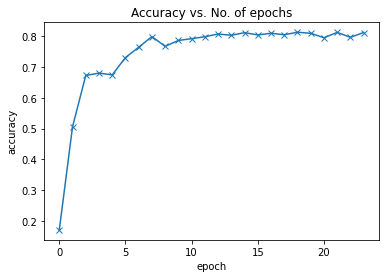

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

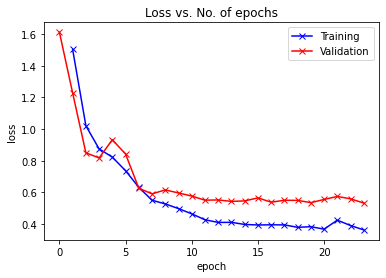

In [ ]:
plot_losses(history)

# Test with individual Image
While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of images.

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [ ]:
def show_image_prediction(img, label):
  plt.imshow(img.permute(1, 2, 0))
  print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: sunflower , Predicted: sunflower


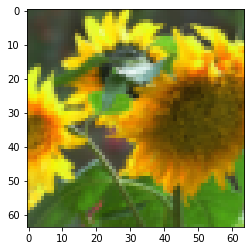

In [ ]:
show_image_prediction(*valid_ds[0])

Label: daisy , Predicted: daisy


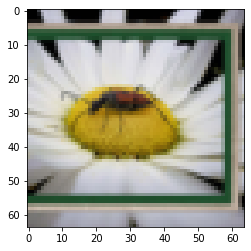

In [ ]:
show_image_prediction(*valid_ds[23])

Label: dandelion , Predicted: daisy


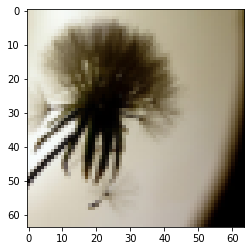

In [ ]:
show_image_prediction(*valid_ds[132])

Label: dandelion , Predicted: dandelion


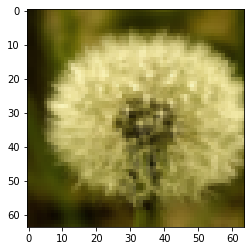

In [ ]:
show_image_prediction(*valid_ds[343])

# Summary
In this project we train Deep Learning models to classify pictures from 5 classes:

- 1.tulip
- 2.dandelion
- 3.sunflower
- 4.daisy
- 5.rose
